In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("CSV.csv")
import matplotlib.pyplot as plt

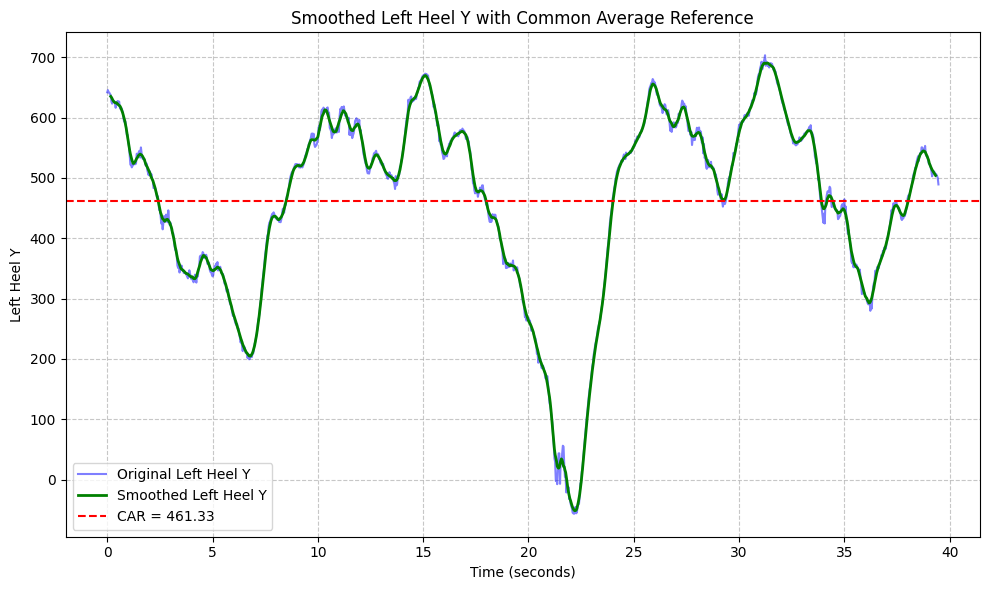

In [ ]:
window_size = 10
df['smoothed_left_heel_y'] = df['left_heel_y'].rolling(window=window_size, center=True).mean()

car = df['left_heel_y'].mean()

plt.figure(figsize=(10, 6))

plt.plot(df.index / 30, df['left_heel_y'], label='Original Left Heel Y', color='blue', alpha=0.5)

plt.plot(df.index / 30, df['smoothed_left_heel_y'], label='Smoothed Left Heel Y', color='green', linewidth=2)

plt.axhline(y=car, color='red', linestyle='--', label=f'CAR = {car:.2f}')

plt.title('Smoothed Left Heel Y with Common Average Reference')
plt.xlabel('Time (seconds)')
plt.ylabel('Left Heel Y')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Number of Left Heel Strikes: 131
Number of Right Heel Strikes: 160


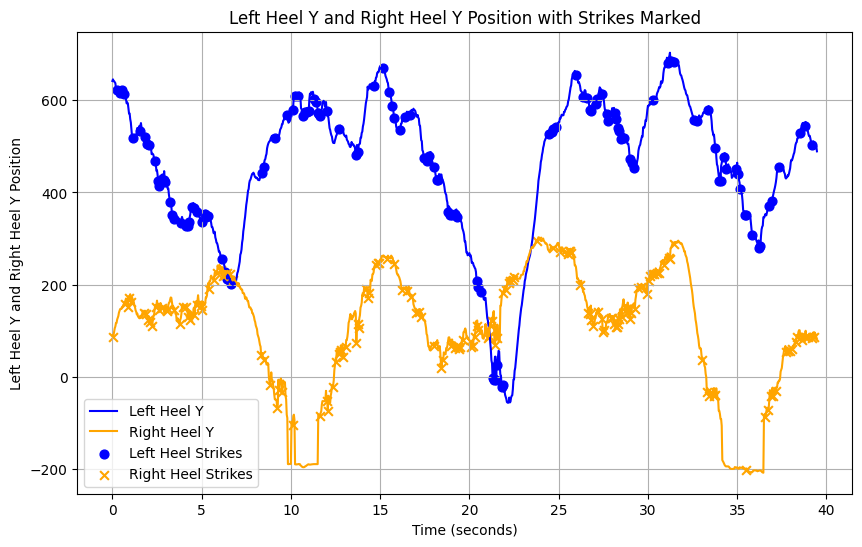

In [ ]:
FPS = 30  
threshold = 2 

l_heel_dips = df.index[
    (df['left_heel_y'].diff() < -threshold) & (df['left_heel_y'].diff().shift(-1) > threshold)
].tolist()
r_heel_dips = df.index[
    (df['right_heel_y'].diff() < -threshold) & (df['right_heel_y'].diff().shift(-1) > threshold)
].tolist()


plt.figure(figsize=(10, 6))
plt.plot(df.index / FPS, df['left_heel_y'], label='Left Heel Y', color='blue')  
plt.plot(df.index / FPS, df['right_heel_y'], label='Right Heel Y', color='orange') 

# Overlay markers for dips
plt.scatter([i / FPS for i in l_heel_dips], df['left_heel_y'].iloc[l_heel_dips],
            color='blue', label='Left Heel Strikes', marker='o', s=40)
plt.scatter([i / FPS for i in r_heel_dips], df['right_heel_y'].iloc[r_heel_dips],
            color='orange', label='Right Heel Strikes', marker='x', s=40)


plt.xlabel('Time (seconds)')
plt.ylabel('Left Heel Y and Right Heel Y Position')
plt.title('Left Heel Y and Right Heel Y Position with Strikes Marked')
plt.legend()
plt.grid()

print(f"Number of Left Heel Strikes: {len(l_heel_dips)}")
print(f"Number of Right Heel Strikes: {len(r_heel_dips)}")

plt.show()


In [18]:
import math
import numpy as np

FPS = 30
threshold = 10
time_tolerance = 0.5
height_to_eyebrows = 1.7

l_heel_dips = df.index[
    (df['left_heel_y'].diff() < -threshold) & (df['left_heel_y'].diff().shift(-1) > threshold)
].tolist()
r_heel_dips = df.index[
    (df['right_heel_y'].diff() < -threshold) & (df['right_heel_y'].diff().shift(-1) > threshold)
].tolist()

l_heel_dips_time = [i / FPS for i in l_heel_dips]
r_heel_dips_time = [i / FPS for i in r_heel_dips]

matching_dips = []
distances = []

for l_time, l_index in zip(l_heel_dips_time, l_heel_dips):
    for r_time, r_index in zip(r_heel_dips_time, r_heel_dips):
        if abs(l_time - r_time) <= time_tolerance:
            matching_dips.append((l_time, r_time))
            left_x, left_y = df.loc[l_index, ['left_heel_x', 'left_heel_y']]
            right_x, right_y = df.loc[r_index, ['right_heel_x', 'right_heel_y']]
            distance = np.sqrt((left_x - right_x)**2 + (left_y - right_y)**2)
            distances.append((l_time, r_time, distance))

scale_factors = []
for _, row in df.iterrows():
    eyebrows_y = row['face-60_y']
    eyebrows_x = row['face-60_x']
    heel_y = min(row['right_heel_y'], row['left_heel_y'])
    heel_x = min(row['right_heel_x'], row['left_heel_x'])
    height_pixels = math.sqrt((heel_y - eyebrows_y) ** 2 + (heel_x - eyebrows_x) ** 2)
    scale_factor = height_to_eyebrows / height_pixels
    scale_factors.append(scale_factor)

real_distances = []
for (l_time, r_time, distance), scale_factor in zip(distances, scale_factors):
    real_distance = distance * scale_factor
    real_distances.append((l_time, r_time, real_distance))

print("Matching dips within ±0.5 seconds:")
print(f"Number of matching dips: {len(matching_dips)}")
for l_time, r_time in matching_dips:
    print(f"Left Heel Time: {l_time:.3f}s, Right Heel Time: {r_time:.3f}s")

print("\nEuclidean Distances (in real-life measurements) at Matching Times:")
for l_time, r_time, real_distance in real_distances:
    print(f"Left Heel Time: {l_time:.3f}s, Right Heel Time: {r_time:.3f}s, Real Distance: {real_distance:.3f} meters")

left_distances = []
right_distances = []

for l_time, r_time, real_distance in real_distances:
    time_diff = l_time - r_time
    if time_diff < 0:
        left_distances.append(real_distance)
    else:
        right_distances.append(real_distance)

avg_left_distance = np.mean(left_distances) if left_distances else 0
avg_right_distance = np.mean(right_distances) if right_distances else 0

if avg_left_distance + avg_right_distance > 0:
    GSI = 100 * abs(avg_left_distance - avg_right_distance) / (0.5 * (avg_left_distance + avg_right_distance))
else:
    GSI = None

print("\nGait Symmetry Index (GSI):")
if GSI is not None:
    print(f"GSI = {GSI:.2f}%")
else:
    print("Insufficient data to calculate GSI.")


Matching dips within ±0.5 seconds:
Number of matching dips: 16
Left Heel Time: 1.567s, Right Heel Time: 1.067s
Left Heel Time: 18.800s, Right Heel Time: 18.433s
Left Heel Time: 21.367s, Right Heel Time: 21.100s
Left Heel Time: 21.367s, Right Heel Time: 21.533s
Left Heel Time: 21.500s, Right Heel Time: 21.100s
Left Heel Time: 21.500s, Right Heel Time: 21.533s
Left Heel Time: 27.767s, Right Heel Time: 28.267s
Left Heel Time: 28.300s, Right Heel Time: 28.267s
Left Heel Time: 28.300s, Right Heel Time: 28.333s
Left Heel Time: 28.300s, Right Heel Time: 28.400s
Left Heel Time: 28.300s, Right Heel Time: 28.533s
Left Heel Time: 28.300s, Right Heel Time: 28.800s
Left Heel Time: 34.000s, Right Heel Time: 33.700s
Left Heel Time: 34.000s, Right Heel Time: 33.767s
Left Heel Time: 34.067s, Right Heel Time: 33.700s
Left Heel Time: 34.067s, Right Heel Time: 33.767s

Euclidean Distances (in real-life measurements) at Matching Times:
Left Heel Time: 1.567s, Right Heel Time: 1.067s, Real Distance: 0.637 m

In [ ]:
#does not work well
import math
import numpy as np

FPS = 30
threshold = 10
height_to_eyebrows = 1.7

l_heel_dips = df.index[
    (df['left_heel_y'].diff() < -threshold) & (df['left_heel_y'].diff().shift(-1) > threshold)
].tolist()
r_heel_dips = df.index[
    (df['right_heel_y'].diff() < -threshold) & (df['right_heel_y'].diff().shift(-1) > threshold)
].tolist()

scale_factors = []
for _, row in df.iterrows():
    eyebrows_y = row['face-60_y']
    eyebrows_x = row['face-60_x']
    heel_y = min(row['right_heel_y'], row['left_heel_y'])
    heel_x = min(row['right_heel_x'], row['left_heel_x'])
    height_pixels = math.sqrt((heel_y - eyebrows_y) ** 2 + (heel_x - eyebrows_x) ** 2)
    scale_factor = height_to_eyebrows / height_pixels
    scale_factors.append(scale_factor)

left_stride_lengths = []
for i in range(len(l_heel_dips) - 1):
    start_index = l_heel_dips[i]
    end_index = l_heel_dips[i + 1]
    stride_distance = 0
    for j in range(start_index, end_index):
        x1, y1 = df.loc[j, ['left_heel_x', 'left_heel_y']]
        x2, y2 = df.loc[j + 1, ['left_heel_x', 'left_heel_y']]
        stride_distance += math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    scale_factor = scale_factors[start_index]
    real_stride_length = stride_distance * scale_factor
    left_stride_lengths.append(real_stride_length)

right_stride_lengths = []
for i in range(len(r_heel_dips) - 1):
    start_index = r_heel_dips[i]
    end_index = r_heel_dips[i + 1]
    stride_distance = 0
    for j in range(start_index, end_index):
        x1, y1 = df.loc[j, ['right_heel_x', 'right_heel_y']]
        x2, y2 = df.loc[j + 1, ['right_heel_x', 'right_heel_y']]
        stride_distance += math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    scale_factor = scale_factors[start_index]
    real_stride_length = stride_distance * scale_factor
    right_stride_lengths.append(real_stride_length)

print("Left Foot Stride Lengths (in meters):")
print(left_stride_lengths)
print("\nRight Foot Stride Lengths (in meters):")
print(right_stride_lengths)


Left Foot Stride Lengths (in meters):
[0.5617339732940558, 12.220692242067862, 2.481006240392694, 4.785318768713771, 66.97669504766877, 0.7167142803340202, 10.181638146430313, 0.04972897569578905, 0.49849223190293407, 0.6736907049449816]

Right Foot Stride Lengths (in meters):
[0.10264008634392366, 1.6617874792341056, 0.40143619625044624, 0.4497277109120807, 0.4246368272605748, 0.839491248163609, 3.7910401939685547, 3.5357633576164895, 0.6213357465484619, 0.12687015133953977, 0.7857022181027944, 0.2712577721176381, 0.6966760303497331, 3.852604191240744, 1.0073191820201584, 0.3306493678058102, 1.3455858542661416, 2.3068695736864484, 6.550008948931756, 7.408962443279482, 1.8927477852725154, 0.13243134910285673, 0.17314826144814083, 0.19134754256954173, 0.48884910126768366, 0.29690867345921496, 0.22499679952121718, 6.606658637307266, 0.05225512099006846, 2.4682928672857067]


In [ ]:
import numpy as np

FPS = 30 
threshold = 10 
time_tolerance = 0.05  

l_heel_dips = df.index[
    (df['left_heel_y'].diff() < -threshold) & (df['left_heel_y'].diff().shift(-1) > threshold)
].tolist()
r_heel_dips = df.index[
    (df['right_heel_y'].diff() < -threshold) & (df['right_heel_y'].diff().shift(-1) > threshold)
].tolist()

l_heel_dips_time = [i / FPS for i in l_heel_dips]
r_heel_dips_time = [i / FPS for i in r_heel_dips]


matching_dips = []
for l_time, l_index in zip(l_heel_dips_time, l_heel_dips):
    for r_time, r_index in zip(r_heel_dips_time, r_heel_dips):
        if abs(l_time - r_time) <= time_tolerance:
        
            matching_dips.append((l_time, l_index, r_index))


distances = []
for l_time, l_index, r_index in matching_dips:
    left_x, left_y = df.loc[l_index, ['left_heel_x', 'left_heel_y']]
    right_x, right_y = df.loc[r_index, ['right_heel_x', 'right_heel_y']]
    distance = np.sqrt((left_x - right_x)**2 + (left_y - right_y)**2)
    distances.append((l_time, distance))

print("Euclidean Distances at Matching Times:")
for l_time, distance in distances:
    print(f"Time: {l_time:.3f}s, Distance: {distance:.3f}")


Euclidean Distances at Matching Times:
Time: 21.500s, Distance: 671.376
Time: 28.300s, Distance: 704.961
Time: 28.300s, Distance: 714.994


Step Lengths (normalized): [np.float64(7.163715691613057), np.float64(6.970971427551466), np.float64(6.977142329952935), np.float64(6.9292736416925775), np.float64(5.5372105045815605), np.float64(5.333828249102696), np.float64(5.896269638723328), np.float64(6.000942345120878), np.float64(6.303309965970439), np.float64(6.1058591855965725), np.float64(6.25209028330118), np.float64(6.262613571852176), np.float64(6.098699783976841), np.float64(5.864616033843036), np.float64(6.9798856236535185), np.float64(7.2342601895945675), np.float64(6.991123245427476), np.float64(7.191781688684939), np.float64(7.140423060766097), np.float64(6.926146882378685), np.float64(6.814057149793721), np.float64(7.743349232000658), np.float64(7.852289113990224), np.float64(7.123581633844538), np.float64(6.81916193671001), np.float64(6.351481445167036), np.float64(6.2229491065884925), np.float64(6.222433903153802), np.float64(6.321293564563631), np.float64(6.52653159892418), np.float64(7.33246348116476), np.float6

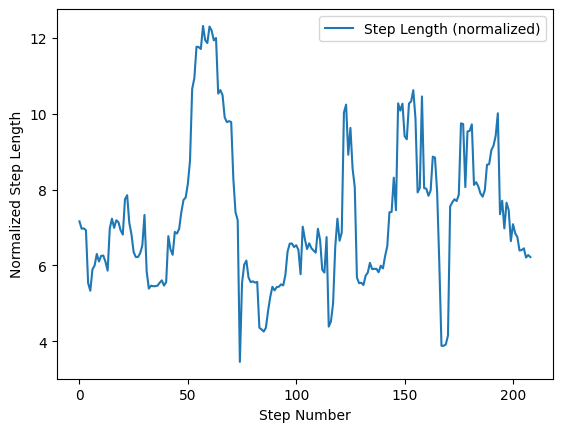

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

threshold = 3
frame_rate = 30
height_in_inches = 69

left_heel_x = df['left_heel_x'].values
left_heel_y = df['left_heel_y'].values
right_heel_x = df['right_heel_x'].values
right_heel_y = df['right_heel_y'].values

def detect_heel_strikes(heel_x, heel_y):
    heel_strikes = []
    swing_start = None
    for frame in range(1, len(heel_x)):
        x_diff = abs(heel_x[frame] - heel_x[frame - 1])
        y_diff = abs(heel_y[frame] - heel_y[frame - 1])
        if x_diff <= threshold and y_diff <= threshold: 
            if swing_start is not None:  
                heel_strikes.append(frame)
                swing_start = None
        else: 
            if swing_start is None:
                swing_start = frame
    return heel_strikes

left_heel_strikes = detect_heel_strikes(left_heel_x, left_heel_y)
right_heel_strikes = detect_heel_strikes(right_heel_x, right_heel_y)

def calculate_step_lengths(left_strikes, right_strikes, left_x, left_y, right_x, right_y, height):
    step_lengths = []
    i, j = 0, 0
    while i < len(left_strikes) and j < len(right_strikes):
        left_strike = left_strikes[i]
        right_strike = right_strikes[j]
        if left_strike < right_strike:
            step_length = np.sqrt(
                (right_x[right_strike] - left_x[left_strike]) ** 2 +
                (right_y[right_strike] - left_y[left_strike]) ** 2
            )
            step_lengths.append(step_length / height)
            i += 1  
        else:
            step_length = np.sqrt(
                (left_x[left_strike] - right_x[right_strike]) ** 2 +
                (left_y[left_strike] - right_y[right_strike]) ** 2
            )
            step_lengths.append(step_length / height)
            j += 1 
    return step_lengths

step_lengths = calculate_step_lengths(
    left_heel_strikes, right_heel_strikes,
    left_heel_x, left_heel_y,
    right_heel_x, right_heel_y,
    height_in_inches
)

print("Step Lengths (normalized):", step_lengths)
print(len(step_lengths))

plt.plot(range(len(step_lengths)), step_lengths, label='Step Length (normalized)')
plt.xlabel("Step Number")
plt.ylabel("Normalized Step Length")
plt.legend()
plt.show()
